In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import pandas_ta as ta
import yfinance as yf

from datetime import datetime, timedelta

%matplotlib widget
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import notebook_utils

product_ids = ["BTC-USD", "ETH-USD"]

In [2]:
def get_df_fear_greed_index():
    print("Retrieving historical fear and greed index")
    fear_greed_index_response = requests.get("https://api.alternative.me/fng/?limit=" + str(24 * 365 * 2))
    df_fear_greed_index = pd.DataFrame(fear_greed_index_response.json()["data"])
    df_fear_greed_index.set_index(
        pd.DatetimeIndex([pd.Timestamp(int(x), unit="s", tz="UTC") for x in df_fear_greed_index.timestamp]),
        inplace=True,
    )
    df_fear_greed_index.rename(columns={"value": "fear_greed_index"}, inplace=True)
    return df_fear_greed_index


def get_df_history(product_id):
    print(f"Retrieving historical data for {product_id}")

    df_history = yf.Ticker(product_id).history(interval="1h", period="2y")[:-1]
    df_history.columns = map(str.lower, df_history.columns)

    timestamps = [pd.to_datetime(x, utc=True) for x in df_history.index.values]
    timestamps_date_range = pd.date_range(start=timestamps[0], end=timestamps[-1], freq="H")
    df_history = df_history.set_index(pd.DatetimeIndex(timestamps)).reindex(timestamps_date_range, method="ffill")

    df_history = df_history.join(df_fear_greed_index[["fear_greed_index"]])
    df_history["fear_greed_index"] = df_history.fear_greed_index.fillna(method="ffill").astype(float)

    def get_strategy_length(x):
        return x * 24

    for column in ["close", "fear_greed_index"]:
        for days in [7, 14, 30, 60, 90, 120]:
            periods = get_strategy_length(days)
            df_history[f"{column}_min_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).min()
            df_history[f"{column}_max_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).max()
            df_history[f"{column}_gradient_{days}"] = df_history[column].diff(periods=periods) / periods
            df_history[f"{column}_gradient_min_{days}"] = df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).min()
            df_history[f"{column}_gradient_max_{days}"] = df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).max()
            # df_history[f"{column}_diff_min_{days}"] = df_history[f"{column}_diff_{days}"].rolling(window=periods, min_periods=1).min()
            # df_history[f"{column}_diff_min_{days}_prev"] = df_history[f"{column}_diff_min_{days}"].shift(int(periods/2))
            # df_history[f"{column}_diff_min_{days}_deriv"] = df_history[f"{column}_diff_min_{days}"].diff()
    
    # df_history["previous_close"] = df_history.close.shift(1)
    # df_history["previous_fear_greed_index"] = df_history.fear_greed_index.shift(1)
    # df_history["close_diff"] = df_history.close.diff(periods=24*14)
    # df_history["fear_greed_index_diff"] = df_history.fear_greed_index.diff(periods=24*14)
    df_history["period_max_close_pct_change"] = (
        (df_history[::-1].close.rolling(window=24, min_periods=1).max().shift(1) - df_history.close)
        / df_history.close
    )
    
    return df_history

df_fear_greed_index = get_df_fear_greed_index()
history_dfs = {}

for product_id in product_ids:
    history_dfs[product_id] = get_df_history(product_id)

Retrieving historical fear and greed index
Retrieving historical data for BTC-USD
Retrieving historical data for ETH-USD


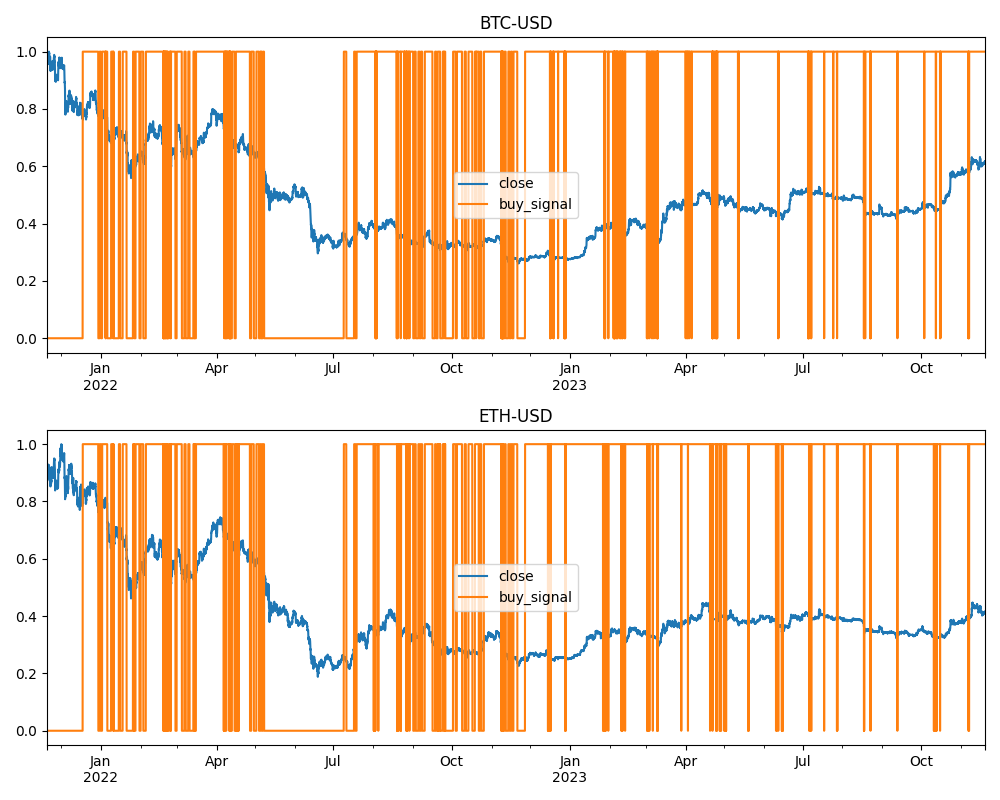

In [3]:
total_products = len(history_dfs)
fig, ax = plt.subplots(nrows=total_products, figsize=(10, 4 * total_products))
days = 14

for product_index, product_id in enumerate(product_ids):
    ax_index = ax if total_products <= 1 else ax[product_index]
    # history_dfs[product_id]["good_buy"] = history_dfs[product_id].fear_greed_index == history_dfs[product_id].fear_greed_index_min_30
    df_history1 = history_dfs[product_id][["close", f"close_min_{days}", f"close_max_{days}"]].copy()
    df_history2 = history_dfs[product_id][[f"close_gradient_{days}", f"close_gradient_min_{days}", f"close_gradient_max_{days}"]].copy()
    df_history3 = history_dfs[product_id][["fear_greed_index", f"fear_greed_index_min_{days}", f"fear_greed_index_max_{days}"]].copy()
    df_history4 = history_dfs[product_id][[f"fear_greed_index_gradient_{days}", f"fear_greed_index_gradient_min_{days}", f"fear_greed_index_gradient_max_{days}"]].copy()
    
    df_history1_max = df_history1.to_numpy()[~np.isnan(df_history1.to_numpy())].max()
    df_history2_max = df_history2.to_numpy()[~np.isnan(df_history2.to_numpy())].max()
    df_history3_max = df_history3.to_numpy()[~np.isnan(df_history3.to_numpy())].max()
    df_history4_max = df_history4.to_numpy()[~np.isnan(df_history4.to_numpy())].max()
    
    for column in df_history1.columns:
        df_history1[column] = df_history1[column] / df_history1_max
    
    for column in df_history2.columns:
        df_history2[column] = df_history2[column] / df_history2_max
    
    for column in df_history3.columns:
        df_history3[column] = df_history3[column] / df_history3_max
    
    for column in df_history4.columns:
        df_history4[column] = df_history4[column] / df_history4_max
    
    df_history = df_history1.join(df_history2, how="outer").join(df_history3, how="outer").join(df_history4, how="outer")
    df_history["buy_signal"] = (
        (df_history.fear_greed_index > .3)
        & (df_history[f"close_gradient_{days}"] > df_history[f"close_gradient_min_{days}"])
        # & (df_history[f"fear_greed_index_gradient_{days}"] > df_history[f"fear_greed_index_gradient_min_{days}"])
    ).replace({True: 1, False: 0})
    
    df_history[[
        "close", "buy_signal",
        # "fear_greed_index",
        # f"close_min_{days}", f"close_max_{days}",
        # f"close_gradient_{days}", f"close_gradient_min_{days}", f"close_gradient_max_{days}",
        # f"fear_greed_index_min_{days}", f"fear_greed_index_max_{days}",
        # f"fear_greed_index_gradient_{days}", f"fear_greed_index_gradient_min_{days}", f"fear_greed_index_gradient_max_{days}"
        # "buy_signal", "sell_signal"
    ]].plot(ax=ax_index)
    
    ax_index.set_title(product_id)

plt.legend()
plt.tight_layout()
plt.show()

# df_history = history_dfs[product_id]
# display(df_history.corr().astype(str)[["period_max_close_pct_change"]])
# display(df_history.describe())

Total fee percentage: 0%
Start money: $2000
Min buy amount: $200
Max buy amount: $2000
35040/35040 -- 100.00%
End money: $2282.25
Pct earned: 14.113%
Total orders: 6594
Avg pct earned per order: 0.002%
Total volume: $127942.25
Total days: 729.0
Avg 30 day volume: $5265.11


,product_id,side,amount,coins,value,money,total_balance,fear_greed_index
timestamp,,,,,,,,
2022-01-18 21:00:00+00:00,BTC-USD,buy,10.0,0.00023581132036192985,42406.78515625,1990.0,2000.0,24.0
2022-01-18 21:00:00+00:00,ETH-USD,buy,10.0,0.00316070893096274,3163.84716796875,1980.0,2000.0,24.0
2022-01-18 22:00:00+00:00,BTC-USD,buy,10.0,0.0002354861427443408,42465.34375,1970.0,2000.0623792144283,24.0
2022-01-18 22:00:00+00:00,ETH-USD,buy,10.0,0.0031454314336263668,3179.214111328125,1960.0,2000.0623792144283,24.0
2022-01-18 23:00:00+00:00,ETH-USD,buy,10.0,0.003160508215276597,3164.048095703125,1950.0,1999.9230089413652,24.0
...,...,...,...,...,...,...,...,...
2023-10-21 02:00:00+00:00,ETH-USD,buy,10.0,0.006265059909252993,1596.1539306640625,25.314375573749203,1823.223811261461,63.0
2023-10-21 02:00:00+00:00,BTC-USD,buy,10.0,0.0003390201087261326,29496.775390625,15.314375573749203,1823.223811261461,63.0
2023-10-21 03:00:00+00:00,ETH-USD,buy,10.0,0.006255839075870835,1598.506591796875,5.314375573749203,1829.422480980468,63.0


,product_id,side,total_orders
0,BTC-USD,buy,3184
1,BTC-USD,sell,108
2,ETH-USD,buy,3199
3,ETH-USD,sell,103


<Axes: xlabel='timestamp'>

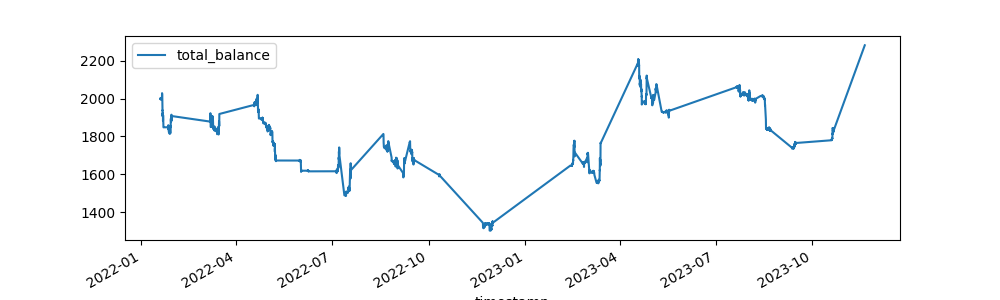

In [21]:
fee_pct = 0
p_keep = 1 - (fee_pct / 2 / 100)
print(f"Total fee percentage: {fee_pct}%")

coins = {}
coins_hold = {}
min_hold = 0
max_hold = 0

for product_id in product_ids:
    coins[product_id] = 0
    coins_hold[product_id] = 0

money = 2000
start_money = money
print(f"Start money: ${start_money}")

min_buy_amount = 200
max_buy_amount = 2000
print(f"Min buy amount: ${min_buy_amount}")
print(f"Max buy amount: ${max_buy_amount}")

total_orders = 0
total_volume = 0
orders = []

total_products = len(product_ids)

# feat_greed_schedule = [
#     {'threshold': 0, 'factor': 1, 'action': 'buy'},
#     {'threshold': 30, 'factor': 1, 'action': 'buy'},
#     # {'threshold': 40, 'factor': 0.25, 'action': 'buy'},
#     # {'threshold': 60, 'factor': 0.25, 'action': 'sell'},
#     {'threshold': 70, 'factor': 1, 'action': 'sell'},
#     {'threshold': 100, 'factor': 1, 'action': 'sell'}
# ]

for product_id in product_ids:
    history_dfs[product_id]["product_id"] = product_id

df_final = pd.concat([history_dfs[product_id] for product_id in product_ids]).sort_index()

total_final = len(df_final)
final_num = 0

for index, row in df_final.iterrows():
    final_num += 1

    if final_num % 100 == 0 or final_num == total_final:
        print(f"{final_num}/{total_final} -- {final_num/total_final*100:.2f}%", end="\r")
        
    product_id = row.product_id

    def get_total_balance():
        total_balance = money

        for coin_product_id in product_ids:
            df_final_product_period = df_final.loc[(df_final.index == index) & (df_final.product_id == coin_product_id)]

            if len(df_final_product_period) > 0:
                total_balance += coins[coin_product_id] * df_final_product_period.close.values[-1] * p_keep

        return total_balance

    def floor_value(x: float, precision: int):
        return np.true_divide(np.floor(x * 10**precision), 10**precision)

    condition_action = None
    condition_factor = None
    
    if (
        row.fear_greed_index > 15
        # and row.fear_greed_index < 90
        # row.fear_greed_index == row.fear_greed_index_min_30
        # money > len(product_ids)
        
        # coins[product_id] * row.close < 1000
        # and row.fear_greed_index < row.fear_greed_index_max_120

        and row.close_gradient_30 > row.close_gradient_min_30
        and pd.to_datetime(index, utc=True) != pd.to_datetime(df_final.index.values[-1], utc=True)
    ):
        condition_action = "buy"
    else:
        condition_action = "sell"

    if condition_action == "buy":
        # condition_factor = (100 - row.fear_greed_index) / 100
        # condition_factor = 1
        # buy_amount = floor_value(money / len(product_ids) * condition_factor, 2)
        # buy_amount = buy_amount if buy_amount >= min_buy_amount else min_buy_amount
        # buy_amount = buy_amount if buy_amount <= max_buy_amount else max_buy_amount
        buy_amount = 10

        if money >= buy_amount and buy_amount > 0:
            money -= buy_amount
            buy_coins = buy_amount / row.close * p_keep
            coins[product_id] += buy_coins
            total_orders += 1
            total_volume += buy_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "buy",
                    "amount": buy_amount,
                    "coins": buy_coins,
                    "value": row.close,
                    "money": money,
                    "total_balance": get_total_balance(),
                    "fear_greed_index": row.fear_greed_index,
                    # "fear_greed_index_min_30": row.fear_greed_index_min_30
                }
            )
    elif condition_action == "sell" and coins[product_id] > 0:
        # condition_factor = row.fear_greed_index / 100
        condition_factor = 1
        sell_coins = floor_value(coins[product_id] * condition_factor, 8)
        coins[product_id] = coins[product_id] - sell_coins
        sell_amount = sell_coins * row.close * p_keep
    
        if sell_amount > 0:
            total_orders += 1
            total_volume += sell_amount
            money += sell_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "sell",
                    "amount": sell_amount,
                    "coins": sell_coins,
                    "value": row.close,
                    "money": money,
                    "total_balance": get_total_balance(),
                    "fear_greed_index": row.fear_greed_index,
                    # "fear_greed_index_min_30": row.fear_greed_index_min_30
                }
            )

print()

money += sum(
    [
        (coins[product_id] * df_final.loc[df_final.product_id == product_id].close.values[-1] * p_keep)
        for product_id in product_ids
    ]
)

print(f"End money: ${money:.2f}")
pct_earned = (money - start_money)/start_money*100
print(f"Pct earned: {pct_earned:.3f}%")
days = (df_final.index.values[-1] - df_final.index.values[0]).astype("timedelta64[D]") / np.timedelta64(1, "D")
print(f"Total orders: {total_orders}")
print(f"Avg pct earned per order: {pct_earned / total_orders:.3f}%")
print(f"Total volume: ${total_volume:.2f}")
print(f"Total days: {days}")
print(f"Avg 30 day volume: ${(total_volume / days * 30):.2f}")

df_orders = pd.DataFrame(orders)
df_orders.set_index("timestamp", inplace=True)
display(df_orders.astype(str))

orders_info = []
for product_id in product_ids:
    for side in ["buy", "sell"]:
        df_orders_product_side = df_orders.loc[(df_orders.product_id == product_id) & (df_orders.side == side)]
        orders_info.append({
            "product_id": product_id,
            "side": side,
            "total_orders": len(df_orders_product_side),
            # "avg_value": df_orders_product_side.value.sum() / len(df_orders_product_side)
        })

df_orders_info = pd.DataFrame(orders_info)
display(df_orders_info)

df_orders[["total_balance"]].plot(figsize=(10, 3))
# df_orders_scaled = df_orders[["total_balance", "fear_greed_index", "fear_greed_index_min_30"]]
# df_orders_scaled = pd.DataFrame(scaler.fit_transform(df_orders_scaled.values), index=df_orders_scaled.index, columns=df_orders_scaled.columns).plot(figsize=(10, 3))

In [9]:
display(df_orders.loc[df_orders.side == "buy"].describe())
display(df_orders.loc[df_orders.side == "sell"].describe())
# df_orders.loc[(df_orders.index >= pd.Timestamp("2022-04-23", tz="UTC")) & (df_orders.index <= pd.Timestamp("2022-07-23", tz="UTC"))]

,amount,coins,value,money,total_balance,fear_greed_index
count,29888.0,29888.000000,29888.000000,29888.000000,29888.000000,29888.000000
mean,10.0,0.002984,15377.225671,429.652540,1049.112553,40.291020
std,0.0,0.002838,14823.738394,298.780458,199.639556,15.360332
min,10.0,0.000186,1038.586792,0.015153,728.404580,16.000000
25%,10.0,0.000369,1767.403503,181.970008,875.231746,26.000000
50%,10.0,0.000626,15978.038574,382.443381,963.915483,40.000000
75%,10.0,0.005658,27069.723145,635.085790,1244.421001,52.000000
max,10.0,0.009628,53679.542969,1567.231540,1612.196291,74.000000


,amount,coins,value,money,total_balance,fear_greed_index
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,298.272091,0.088816,14763.120288,736.125360,1016.397928,38.750996
std,310.991740,0.152488,14659.899259,318.101323,187.766877,14.919450
min,9.530783,0.000209,1043.112915,11.101106,731.097560,10.000000
25%,29.940001,0.005293,1733.676605,509.368957,869.942152,26.000000
50%,175.423205,0.019004,3816.136230,789.540252,937.895153,34.000000
75%,502.117207,0.082003,26125.182617,926.324842,1220.400732,52.000000
max,1497.740306,0.751354,50984.054688,1585.178870,1585.179052,72.000000
